In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

/home/hardik/Desktop/Research/Adversary-CBF/venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Exact GP

In [62]:
# Training data is 100 points in [0,1] inclusive regularly spaced
train_x1 = torch.linspace(0, 1, 100)
# True function is sin(2*pi*x) with Gaussian noise
train_y1 = torch.sin(train_x1 * (2 * math.pi)) + torch.randn(train_x1.size()) * math.sqrt(0.04)

In [63]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood1 = gpytorch.likelihoods.GaussianLikelihood()
model1 = ExactGPModel(train_x1, train_y1, likelihood1)

In [64]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 50


# Find optimal model hyperparameters
model1.train()
likelihood1.train()

# Use the adam optimizer
optimizer1 = torch.optim.Adam(model1.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll1 = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood1, model1)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer1.zero_grad()
    # Output from model
    output1 = model1(train_x1)
    # Calc loss and backprop gradients
    loss1 = -mll1(output1, train_y1)
    loss1.backward()
#     print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
#         i + 1, training_iter, loss1.item(),
#         model1.covar_module.base_kernel.lengthscale.item(),
#         model1.likelihood.noise.item()
#     ))
    optimizer1.step()

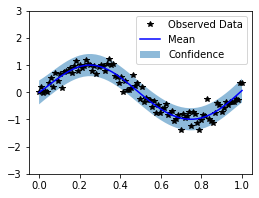

In [65]:
# Get into evaluation (predictive posterior) mode
model1.eval()
likelihood1.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 1, 51)
    observed_pred = likelihood1(model1(test_x))

with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x1.numpy(), train_y1.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])

In [66]:
xx1 = torch.tensor([0], dtype=torch.float, requires_grad=True)

In [67]:
yy1 = model1(xx1)

In [68]:
yy1.mean.sum().backward(retain_graph=True)

In [69]:
yy1.covariance_matrix

tensor([[0.0085]], grad_fn=<AddmmBackward0>)

In [70]:
xx1.grad

tensor([5.3661])

## Multitask GP

In [85]:
train_x2 = torch.linspace(0, 1, 100)

train_y2 = torch.stack([
    torch.sin(train_x2 * (2 * math.pi)) + torch.randn(train_x2.size()) * 0.2,
    torch.cos(train_x2 * (2 * math.pi)) + torch.randn(train_x2.size()) * 0.2,
], -1)

In [86]:
train_y2.shape

torch.Size([100, 2])

In [87]:
class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ConstantMean(), num_tasks=2
        )
        self.covar_module = gpytorch.kernels.MultitaskKernel(
            gpytorch.kernels.RBFKernel(), num_tasks=2, rank=1
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)


likelihood2 = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=2)
model2 = MultitaskGPModel(train_x2, train_y2, likelihood2)

In [88]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iterations = 2 if smoke_test else 50


# Find optimal model hyperparameters
model2.train()
likelihood2.train()

# Use the adam optimizer
optimizer2 = torch.optim.Adam(model2.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll2 = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood2, model2)

for i in range(training_iterations):
    optimizer2.zero_grad()
    output2 = model2(train_x2)
    loss2 = -mll2(output2, train_y2)
    loss2.backward()
#     print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss2.item()))
    optimizer2.step()


Text(0.5, 1.0, 'Observed Values (Likelihood)')

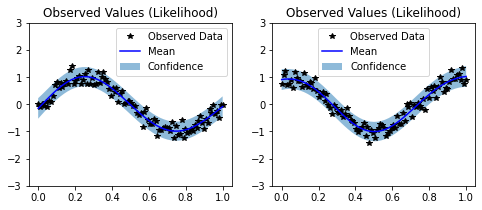

In [89]:
# Set into eval mode
model2.eval()
likelihood2.eval()

# Initialize plots
f, (y1_ax, y2_ax) = plt.subplots(1, 2, figsize=(8, 3))

# Make predictions
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 1, 51)
    predictions = likelihood2(model2(test_x))
    mean = predictions.mean
    lower, upper = predictions.confidence_region()

# This contains predictions for both tasks, flattened out
# The first half of the predictions is for the first task
# The second half is for the second task

# Plot training data as black stars
y1_ax.plot(train_x2.detach().numpy(), train_y2[:, 0].detach().numpy(), 'k*')
# Predictive mean as blue line
y1_ax.plot(test_x.numpy(), mean[:, 0].numpy(), 'b')
# Shade in confidence
y1_ax.fill_between(test_x.numpy(), lower[:, 0].numpy(), upper[:, 0].numpy(), alpha=0.5)
y1_ax.set_ylim([-3, 3])
y1_ax.legend(['Observed Data', 'Mean', 'Confidence'])
y1_ax.set_title('Observed Values (Likelihood)')

# Plot training data as black stars
y2_ax.plot(train_x2.detach().numpy(), train_y2[:, 1].detach().numpy(), 'k*')
# Predictive mean as blue line
y2_ax.plot(test_x.numpy(), mean[:, 1].numpy(), 'b')
# Shade in confidence
y2_ax.fill_between(test_x.numpy(), lower[:, 1].numpy(), upper[:, 1].numpy(), alpha=0.5)
y2_ax.set_ylim([-3, 3])
y2_ax.legend(['Observed Data', 'Mean', 'Confidence'])
y2_ax.set_title('Observed Values (Likelihood)')

# None

In [75]:
xx2 = torch.tensor([0], dtype=torch.float, requires_grad=True)

In [76]:
yy2 = model2(xx2)

In [77]:
yy2.mean.sum().backward(retain_graph=True)

In [78]:
xx2.grad

tensor([1.6290])

## GP with derivative

In [79]:
lb, ub = 0.0, 5*math.pi
n = 50

train_x3 = torch.linspace(lb, ub, n).unsqueeze(-1)
train_y3 = torch.stack([
    torch.sin(2*train_x3) + torch.cos(train_x3), 
    -torch.sin(train_x3) + 2*torch.cos(2*train_x3)
], -1).squeeze(1)

train_y3 += 0.05 * torch.randn(n, 2)

In [90]:
class GPModelWithDerivatives(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPModelWithDerivatives, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMeanGrad()
        self.base_kernel = gpytorch.kernels.RBFKernelGrad()
        self.covar_module = gpytorch.kernels.ScaleKernel(self.base_kernel)

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)

likelihood3 = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=2)  # Value + Derivative
likelihood3.initialize(noise=0.01*train_y3.std())  # Require 1% noise (approximately)
likelihood3.raw_noise.requires_grad = False
model3 = GPModelWithDerivatives(train_x3, train_y3, likelihood3)

In [91]:
# Find optimal model hyperparameters
model3.train()
likelihood3.train()

# Use the adam optimizer
optimizer3 = torch.optim.Adam([
    {'params': model3.parameters()},  # Includes GaussianLikelihood parameters
], lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll3 = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood3, model3)

n_iter = 50
for i in range(n_iter):
    optimizer3.zero_grad()
    output3 = model3(train_x3)
    loss3 = -mll3(output3, train_y3)
    loss3.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, n_iter, loss3.item(),
        model3.covar_module.base_kernel.lengthscale.item(),
        model3.likelihood.noise.item()
    ))        
    optimizer3.step()

Iter 1/50 - Loss: 1.116   lengthscale: 0.693   noise: 0.014
Iter 2/50 - Loss: 1.074   lengthscale: 0.744   noise: 0.014
Iter 3/50 - Loss: 1.034   lengthscale: 0.797   noise: 0.014
Iter 4/50 - Loss: 0.996   lengthscale: 0.851   noise: 0.014
Iter 5/50 - Loss: 0.961   lengthscale: 0.904   noise: 0.014
Iter 6/50 - Loss: 0.928   lengthscale: 0.953   noise: 0.014
Iter 7/50 - Loss: 0.896   lengthscale: 0.993   noise: 0.014
Iter 8/50 - Loss: 0.863   lengthscale: 1.022   noise: 0.014
Iter 9/50 - Loss: 0.829   lengthscale: 1.037   noise: 0.014
Iter 10/50 - Loss: 0.794   lengthscale: 1.041   noise: 0.014
Iter 11/50 - Loss: 0.758   lengthscale: 1.037   noise: 0.014
Iter 12/50 - Loss: 0.722   lengthscale: 1.028   noise: 0.014
Iter 13/50 - Loss: 0.688   lengthscale: 1.020   noise: 0.014
Iter 14/50 - Loss: 0.653   lengthscale: 1.013   noise: 0.014
Iter 15/50 - Loss: 0.619   lengthscale: 1.012   noise: 0.014
Iter 16/50 - Loss: 0.584   lengthscale: 1.016   noise: 0.014
Iter 17/50 - Loss: 0.549   length

Text(0.5, 1.0, 'Derivatives')

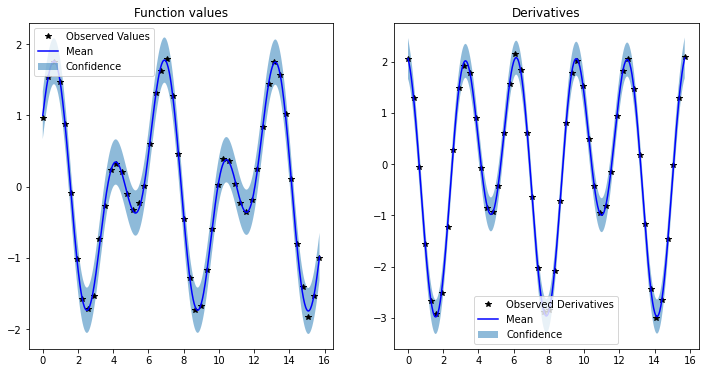

In [92]:
# Set into eval mode
model3.train()
model3.eval()
likelihood3.eval()

# Initialize plots
f, (y1_ax, y2_ax) = plt.subplots(1, 2, figsize=(12, 6))

# Make predictions
with torch.no_grad(), gpytorch.settings.max_cg_iterations(50):
    test_x = torch.linspace(lb, ub, 500)
    predictions = likelihood3(model3(test_x))
    mean = predictions.mean
    lower, upper = predictions.confidence_region()
    
# Plot training data as black stars
y1_ax.plot(train_x3.detach().numpy(), train_y3[:, 0].detach().numpy(), 'k*')
# Predictive mean as blue line
y1_ax.plot(test_x.numpy(), mean[:, 0].numpy(), 'b')
# Shade in confidence 
y1_ax.fill_between(test_x.numpy(), lower[:, 0].numpy(), upper[:, 0].numpy(), alpha=0.5)
y1_ax.legend(['Observed Values', 'Mean', 'Confidence'])
y1_ax.set_title('Function values')

# Plot training data as black stars
y2_ax.plot(train_x3.detach().numpy(), train_y3[:, 1].detach().numpy(), 'k*')
# Predictive mean as blue line
y2_ax.plot(test_x.numpy(), mean[:, 1].numpy(), 'b')
# Shade in confidence 
y2_ax.fill_between(test_x.numpy(), lower[:, 1].numpy(), upper[:, 1].numpy(), alpha=0.5)
y2_ax.legend(['Observed Derivatives', 'Mean', 'Confidence'])
y2_ax.set_title('Derivatives')

In [93]:
a.m = 3

NameError: name 'a' is not defined